In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
!pip install -q phik
import phik # импорт библиотеки корреляции смешанного набора признаков
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Читаем json из файла
with open("/content/instances_default.json", "r") as f:
    data = json.load(f)

# Функция создает переменные-датафреймы
def convert_to_dataframes(data):
    for key, value in data.items():
        if isinstance(value, list):
            globals()[f"{key}_df"] = pd.DataFrame(value)
        elif isinstance(value, dict):
            globals()[f"{key}_df"] = pd.DataFrame([value])

# Создаем переменные-датафреймы
convert_to_dataframes(data)

# Вывод фреймов на экран
for var_name in dir():
    var = globals()[var_name]
    if isinstance(var, pd.DataFrame):
        print(f"Dataframe for {var_name}:")
        display(var)
        print('-' * 30)

Dataframe for annotations_df:


,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
0,1,1,2,[],12677.0917,"[98.87, 141.25, 110.63, 114.59]",0,"{'occluded': False, 'rotation': 0.0}"
1,2,1,2,[],16279.1769,"[723.17, 184.07, 130.83, 124.43]",0,"{'occluded': False, 'rotation': 0.0}"
2,3,1,2,[],13944.2534,"[475.7, 48.84, 116.62, 119.57]",0,"{'occluded': False, 'rotation': 0.0}"
3,4,1,2,[],13847.1183,"[593.81, 62.38, 118.89, 116.47]",0,"{'occluded': False, 'rotation': 0.0}"
4,5,1,2,[],10862.9570,"[0.0, 259.95, 81.34, 133.55]",0,"{'occluded': False, 'rotation': 0.0}"
...,...,...,...,...,...,...,...,...
38326,38327,252,2,[],281438.1400,"[0.0, 1383.28, 480.68, 585.5]",0,"{'occluded': False, 'rotation': 0.0}"
38327,38328,252,2,[],294588.0000,"[0.0, 919.61, 630.0, 467.6]",0,"{'occluded': False, 'rotation': 0.0}"
38328,38329,252,2,[],260243.7787,"[119.17, 510.94, 624.79, 416.53]",0,"{'occluded': False, 'rotation': 0.0}"
38329,38330,252,2,[],191619.1400,"[268.49, 173.01, 573.71, 334.0]",0,"{'occluded': False, 'rotation': 0.0}"


------------------------------
Dataframe for categories_df:


,id,name,supercategory
0,1,window,
1,2,empty,
2,3,filled,


------------------------------
Dataframe for images_df:


,id,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,854,572,0000019949building.jpg,0,,,0
1,2,881,720,0000019869building.jpg,0,,,0
2,3,847,544,0000019458building.jpg,0,,,0
3,4,303,600,0000019455building.jpg,0,,,0
4,5,869,676,0000019431building.jpg,0,,,0
...,...,...,...,...,...,...,...,...
247,248,4160,3120,20221212_151102.jpg,0,,,0
248,249,4160,3120,20221212_150454.jpg,0,,,0
249,250,4160,3120,20221212_145947.jpg,0,,,0
250,251,4160,3120,20221212_144915.jpg,0,,,0


------------------------------
Dataframe for info_df:


,contributor,date_created,description,url,version,year
0,,,,,,


------------------------------
Dataframe for licenses_df:


,name,id,url
0,,0,


------------------------------


In [ ]:
# Разделяем содержание колонки attributes на 2е дополнительные
# Создание исходного датафрейма attributes_df
attributes_df = pd.DataFrame(annotations_df.attributes)

# Разделение словарей на отдельные столбцы
attributes_df['attributes_occluded'] = attributes_df['attributes'].apply(lambda x: x['occluded'])
attributes_df['attributes_rotation'] = attributes_df['attributes'].apply(lambda x: x['rotation'])

# Объединение attributes_df с annotations_df
annotations_df = pd.concat([annotations_df, attributes_df], axis=1)

# Удаление столбца 'attributes'
annotations_df.drop('attributes', axis=1, inplace=True)

# Замена числовых категорий словестными
annotations_df['category_name'] = annotations_df['category_id'].replace({1: 'window', 2: 'empty', 3: 'filled'})

# Избавляемся от скобок
annotations_df['bbox'] = annotations_df['bbox'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
annotations_df['segmentation'] = annotations_df['segmentation'].apply(lambda x: str(x).replace('[', '').replace(']', ''))

annotations_df

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes_occluded,attributes_rotation,category_name
0,1,1,2,,12677.0917,"98.87, 141.25, 110.63, 114.59",0,False,0.0,empty
1,2,1,2,,16279.1769,"723.17, 184.07, 130.83, 124.43",0,False,0.0,empty
2,3,1,2,,13944.2534,"475.7, 48.84, 116.62, 119.57",0,False,0.0,empty
3,4,1,2,,13847.1183,"593.81, 62.38, 118.89, 116.47",0,False,0.0,empty
4,5,1,2,,10862.9570,"0.0, 259.95, 81.34, 133.55",0,False,0.0,empty
...,...,...,...,...,...,...,...,...,...,...
38326,38327,252,2,,281438.1400,"0.0, 1383.28, 480.68, 585.5",0,False,0.0,empty
38327,38328,252,2,,294588.0000,"0.0, 919.61, 630.0, 467.6",0,False,0.0,empty
38328,38329,252,2,,260243.7787,"119.17, 510.94, 624.79, 416.53",0,False,0.0,empty
38329,38330,252,2,,191619.1400,"268.49, 173.01, 573.71, 334.0",0,False,0.0,empty


In [ ]:
# Объединение данных по столбцам "image_id" и "id"
merged_df = pd.merge(annotations_df, images_df, left_on="image_id", right_on="id")

# Результат объединения
merged_df

,id_x,image_id,category_id,segmentation,area,bbox,iscrowd,attributes_occluded,attributes_rotation,category_name,id_y,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,1,2,,12677.0917,"98.87, 141.25, 110.63, 114.59",0,False,0.0,empty,1,854,572,0000019949building.jpg,0,,,0
1,2,1,2,,16279.1769,"723.17, 184.07, 130.83, 124.43",0,False,0.0,empty,1,854,572,0000019949building.jpg,0,,,0
2,3,1,2,,13944.2534,"475.7, 48.84, 116.62, 119.57",0,False,0.0,empty,1,854,572,0000019949building.jpg,0,,,0
3,4,1,2,,13847.1183,"593.81, 62.38, 118.89, 116.47",0,False,0.0,empty,1,854,572,0000019949building.jpg,0,,,0
4,5,1,2,,10862.9570,"0.0, 259.95, 81.34, 133.55",0,False,0.0,empty,1,854,572,0000019949building.jpg,0,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38326,38327,252,2,,281438.1400,"0.0, 1383.28, 480.68, 585.5",0,False,0.0,empty,252,4160,3120,20221212_144514.jpg,0,,,0
38327,38328,252,2,,294588.0000,"0.0, 919.61, 630.0, 467.6",0,False,0.0,empty,252,4160,3120,20221212_144514.jpg,0,,,0
38328,38329,252,2,,260243.7787,"119.17, 510.94, 624.79, 416.53",0,False,0.0,empty,252,4160,3120,20221212_144514.jpg,0,,,0
38329,38330,252,2,,191619.1400,"268.49, 173.01, 573.71, 334.0",0,False,0.0,empty,252,4160,3120,20221212_144514.jpg,0,,,0


In [ ]:
# Смена имени столбца
merged_df = merged_df.rename(columns={'id_x': 'id'})

# Удаление лишних столбцов
merged_df.drop('segmentation', axis=1, inplace=True)
merged_df.drop('iscrowd', axis=1, inplace=True)
merged_df.drop('id_y', axis=1, inplace=True)
merged_df.drop('license', axis=1, inplace=True)
merged_df.drop('flickr_url', axis=1, inplace=True)
merged_df.drop('coco_url', axis=1, inplace=True)
merged_df.drop('date_captured', axis=1, inplace=True)

In [ ]:
merged_df

,id,image_id,category_id,area,bbox,attributes_occluded,attributes_rotation,category_name,width,height,file_name
0,1,1,2,12677.0917,"98.87, 141.25, 110.63, 114.59",False,0.0,empty,854,572,0000019949building.jpg
1,2,1,2,16279.1769,"723.17, 184.07, 130.83, 124.43",False,0.0,empty,854,572,0000019949building.jpg
2,3,1,2,13944.2534,"475.7, 48.84, 116.62, 119.57",False,0.0,empty,854,572,0000019949building.jpg
3,4,1,2,13847.1183,"593.81, 62.38, 118.89, 116.47",False,0.0,empty,854,572,0000019949building.jpg
4,5,1,2,10862.9570,"0.0, 259.95, 81.34, 133.55",False,0.0,empty,854,572,0000019949building.jpg
...,...,...,...,...,...,...,...,...,...,...,...
38326,38327,252,2,281438.1400,"0.0, 1383.28, 480.68, 585.5",False,0.0,empty,4160,3120,20221212_144514.jpg
38327,38328,252,2,294588.0000,"0.0, 919.61, 630.0, 467.6",False,0.0,empty,4160,3120,20221212_144514.jpg
38328,38329,252,2,260243.7787,"119.17, 510.94, 624.79, 416.53",False,0.0,empty,4160,3120,20221212_144514.jpg
38329,38330,252,2,191619.1400,"268.49, 173.01, 573.71, 334.0",False,0.0,empty,4160,3120,20221212_144514.jpg



Вывод первых 10-и строк


,id,image_id,category_id,area,bbox,attributes_occluded,attributes_rotation,category_name,width,height,file_name
0,1,1,2,12677.0917,"98.87, 141.25, 110.63, 114.59",False,0.0,empty,854,572,0000019949building.jpg
1,2,1,2,16279.1769,"723.17, 184.07, 130.83, 124.43",False,0.0,empty,854,572,0000019949building.jpg
2,3,1,2,13944.2534,"475.7, 48.84, 116.62, 119.57",False,0.0,empty,854,572,0000019949building.jpg
3,4,1,2,13847.1183,"593.81, 62.38, 118.89, 116.47",False,0.0,empty,854,572,0000019949building.jpg
4,5,1,2,10862.9570,"0.0, 259.95, 81.34, 133.55",False,0.0,empty,854,572,0000019949building.jpg
5,6,1,2,20953.3496,"464.75, 286.08, 130.64, 160.39",False,0.0,empty,854,572,0000019949building.jpg
6,7,1,2,8335.2766,"0.0, 146.41, 72.74, 114.59",False,0.0,empty,854,572,0000019949building.jpg
7,8,1,2,18738.5815,"217.67, 266.84, 127.43, 147.05",False,0.0,empty,854,572,0000019949building.jpg
8,9,1,2,8532.3714,"0.0, 30.29, 74.46, 114.59",False,0.0,empty,854,572,0000019949building.jpg
9,10,1,2,17569.5684,"342.98, 273.53, 116.92, 150.27",False,0.0,empty,854,572,0000019949building.jpg



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38331 entries, 0 to 38330
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38331 non-null  int64  
 1   image_id             38331 non-null  int64  
 2   category_id          38331 non-null  int64  
 3   area                 38331 non-null  float64
 4   bbox                 38331 non-null  object 
 5   attributes_occluded  38331 non-null  bool   
 6   attributes_rotation  38331 non-null  float64
 7   category_name        38331 non-null  object 
 8   width                38331 non-null  int64  
 9   height               38331 non-null  int64  
 10  file_name            38331 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 3.3+ MB


,id,image_id,category_id,area,attributes_rotation,width,height
count,38331.000000,38331.000000,38331.000000,3.833100e+04,38331.000000,38331.000000,38331.000000
mean,19166.000000,117.856122,2.054003,1.503191e+04,0.056312,1604.630717,1046.817641
std,11065.350921,68.447030,0.827933,5.474662e+04,4.486899,1120.216122,756.074249
min,1.000000,1.000000,1.000000,1.831840e+01,0.000000,247.000000,247.000000
25%,9583.500000,54.000000,1.000000,7.933937e+02,0.000000,825.000000,600.000000
50%,19166.000000,117.000000,2.000000,1.842728e+03,0.000000,1350.000000,720.000000
75%,28748.500000,186.000000,3.000000,4.082751e+03,0.000000,1889.000000,1056.000000
max,38331.000000,252.000000,3.000000,2.587830e+06,359.200000,4177.000000,4032.000000



Количество пропущенных значений для каждого столбца


id                     0
image_id               0
category_id            0
area                   0
bbox                   0
attributes_occluded    0
attributes_rotation    0
category_name          0
width                  0
height                 0
file_name              0
dtype: int64


Процент(доля) пропусков


id                     0.0
image_id               0.0
category_id            0.0
area                   0.0
bbox                   0.0
attributes_occluded    0.0
attributes_rotation    0.0
category_name          0.0
width                  0.0
height                 0.0
file_name              0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце id


,id
0,1
1,2
2,3
3,4
4,5
...,...
38326,38327
38327,38328
38328,38329
38329,38330


Количество уникальных значений id


,value_count
1,1
2,1
3,1
4,1
5,1
...,...
38327,1
38328,1
38329,1
38330,1




Уникальные значения в столбце image_id


,image_id
0,1
1,2
2,3
3,4
4,5
...,...
247,248
248,249
249,250
250,251


Количество уникальных значений image_id


,value_count
1,20
2,27
3,13
4,140
5,24
...,...
248,93
249,40
250,69
251,146




Уникальные значения в столбце category_id


,category_id
1,1
0,2
2,3


Количество уникальных значений category_id


,value_count
1,12158
2,11945
3,14228




Уникальные значения в столбце area


,area
20894,1.831840e+01
24595,2.278470e+01
22849,2.339280e+01
21795,2.425560e+01
11852,2.879200e+01
...,...
36854,1.109891e+06
36133,1.134365e+06
36172,1.227673e+06
36138,1.714535e+06


Количество уникальных значений area


,value_count
1.831840e+01,1
2.278470e+01,1
2.339280e+01,1
2.425560e+01,1
2.879200e+01,1
...,...
1.109891e+06,1
1.134365e+06,1
1.227673e+06,1
1.714535e+06,1




Уникальные значения в столбце bbox


,bbox
37506,"0.0, 0.0, 1058.32, 723.13"
32396,"0.0, 0.0, 81.9, 61.9"
25365,"0.0, 0.0, 9.52, 16.57"
27644,"0.0, 1001.54, 276.0, 239.09"
35281,"0.0, 1004.88, 17.77, 38.38"
...,...
15944,"999.66, 364.38, 8.28, 25.09"
29635,"999.71, 990.06, 59.81, 28.94"
36608,"999.96, 1415.37, 266.48, 239.06"
35766,"999.97, 769.47, 15.93, 69.2"


Количество уникальных значений bbox


,value_count
"0.0, 0.0, 1058.32, 723.13",1
"0.0, 0.0, 81.9, 61.9",1
"0.0, 0.0, 9.52, 16.57",1
"0.0, 1001.54, 276.0, 239.09",1
"0.0, 1004.88, 17.77, 38.38",1
...,...
"999.66, 364.38, 8.28, 25.09",1
"999.71, 990.06, 59.81, 28.94",1
"999.96, 1415.37, 266.48, 239.06",1
"999.97, 769.47, 15.93, 69.2",1




Уникальные значения в столбце attributes_occluded


,attributes_occluded
0,False


Количество уникальных значений attributes_occluded


,value_count
False,38331




Уникальные значения в столбце attributes_rotation


,attributes_rotation
0,0.0
8,0.8
7,0.9
5,1.0
4,1.2
2,2.7
9,357.9
6,358.5
3,358.6
1,359.2


Количество уникальных значений attributes_rotation


,value_count
0.0,38320
0.8,1
0.9,1
1.0,1
1.2,1
2.7,1
357.9,1
358.5,2
358.6,1
359.2,2




Уникальные значения в столбце category_name


,category_name
0,empty
2,filled
1,window


Количество уникальных значений category_name


,value_count
empty,11945
filled,14228
window,12158




Уникальные значения в столбце width


,width
31,247
10,268
30,286
3,303
26,310
...,...
105,4105
118,4108
106,4123
147,4160


Количество уникальных значений width


,value_count
247,448
268,290
286,244
303,272
310,304
...,...
4105,61
4108,52
4123,75
4160,1790




Уникальные значения в столбце height


,height
66,247
39,255
50,308
73,315
125,319
...,...
100,2557
99,2605
86,3024
138,3120


Количество уникальных значений height


,value_count
247,17
255,201
308,73
315,14
319,18
...,...
2557,75
2605,61
3024,1057
3120,1790




Уникальные значения в столбце file_name


,file_name
121,0000000111building.jpg
120,0000000113building.jpg
119,0000000131building.jpg
118,0000000154building.jpg
117,0000000247building.jpg
...,...
217,IMG_20221201_184831_856.jpg
216,IMG_6893.JPG
215,IMG_6896.JPG
214,IMG_6958.JPG


Количество уникальных значений file_name


,value_count
0000000111building.jpg,321
0000000113building.jpg,295
0000000131building.jpg,294
0000000154building.jpg,327
0000000247building.jpg,16
...,...
IMG_20221201_184831_856.jpg,52
IMG_6893.JPG,243
IMG_6896.JPG,114
IMG_6958.JPG,192





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков
корреляция смешанных текстовых и числовых признаков

Гистограммы для всех числовых столбцов таблицы


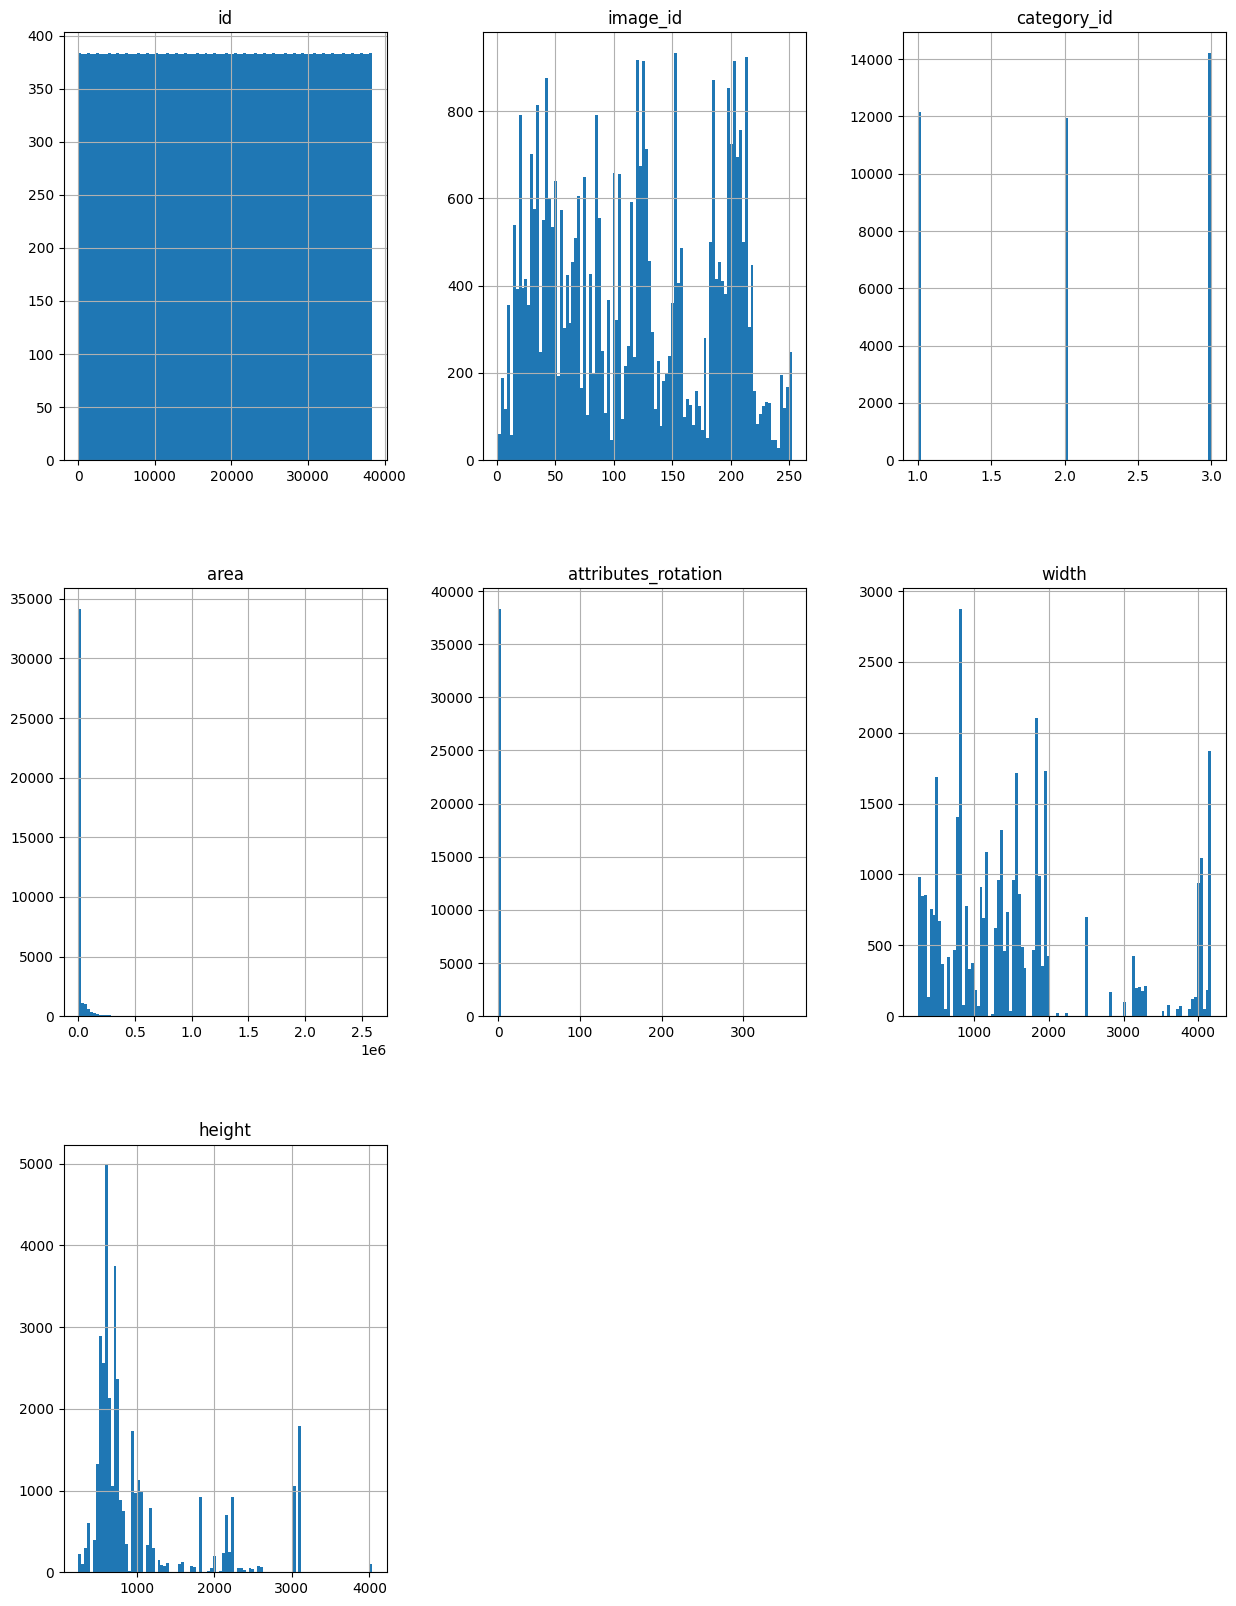

In [ ]:
d = merged_df

# print(n,'-----------------------------------------------------------------------------------------------------------------')
print()
print('Вывод первых 10-и строк')
display(d.head(10)) # вывод первых 10-и строк
print()
print('Вывод основной информации о датафрейме')
print()
d.info() # вывод основной информации о датафрейме
display(d.describe())
print()
print('Количество пропущенных значений для каждого столбца')
display(d.isna().sum()) # количество пропущенных значений для каждого столбца
print()
print('Процент(доля) пропусков')
display(d.isna().mean()*100) # процент(доля) пропусков
print()
print('Проверка уникальных значений столбцов')
# проверка уникальных значений столбцов
# Получение списка уникальных значений для каждого столбца и их количество
for col in d.columns:
    unique_values = pd.Series(d[col].unique()).to_frame(name=col).sort_values(by=col, ascending=True)
    unique_value_counts = pd.Series(d[col].value_counts()).to_frame(name='value_count').sort_index(ascending=True)
    print("Уникальные значения в столбце", col)
    display(unique_values)
    print('Количество уникальных значений', col)
    display(unique_value_counts)
    print("\n")
print()
print('Количество строк-дубликатов в данных')
display(d.duplicated().sum()) # количество строк-дубликатов в данных
print()
print('Корреляция колличественных признаков')
#sb.heatmap(d.corr()) plt.show()                            # гистограмма корр. №1
#sb.heatmap(d.corr(), cmap="YlGnBu", annot=True) plt.show() # гистограмма корр. №2
                                                            # гистограмма корр. №3
#try:
#    display(d.corr()) # корреляция колличественных признаков
#    sb.heatmap(d.corr(), annot=True, cmap='summer', mask=np.triu(d.corr()), fmt=".1f", annot_kws={'size': 15})
#    sb.set(rc={'figure.figsize':(15,20)}) # размер графика
#    plt.show()
#except Exception:
#    pass
#    display(d.phik_matrix()) # корреляция смешанных текстовых и числовых признаков
#    sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
#    sb.set(rc={'figure.figsize':(15,20)}) # размер графика
#    plt.show()
#    print()
                                                            # гистограмма корр. №4
print('корреляция смешанных текстовых и числовых признаков')
#display(d.phik_matrix()) # корреляция смешанных текстовых и числовых признаков
#sb.set(rc={'figure.figsize':(15,20)}) # размер графика
#sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
#plt.show()
print()
print('Гистограммы для всех числовых столбцов таблицы')
try:
    d.hist(figsize=(15, 20), bins=100); # гистограммы для всех числовых столбцов таблицы
    plt.show()
except Exception:
    pass
    print()
    print()

interval columns not set, guessing: ['id', 'image_id', 'category_id', 'area', 'attributes_rotation', 'width', 'height']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bbox is large: 38330. Are you sure this is not an interval variable? Analysis for pairs of variables including bbox can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable attributes_occluded for analysis 1. Dropping this column
  warnings.warn(


,id,image_id,category_id,area,bbox,attributes_rotation,category_name,width,height,file_name
id,1.000000,0.977041,0.422734,0.123249,1.0,0.035475,0.422734,0.817227,0.585387,0.999752
image_id,0.977041,1.000000,0.377784,0.172703,1.0,0.043222,0.377784,0.812380,0.659412,1.000000
category_id,0.422734,0.377784,1.000000,0.114885,1.0,0.010319,1.000000,0.494998,0.526015,0.889391
area,0.123249,0.172703,0.114885,1.000000,1.0,0.170376,0.114885,0.189698,0.184006,0.746097
bbox,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
attributes_rotation,0.035475,0.043222,0.010319,0.170376,1.0,1.000000,0.010319,0.030977,0.033361,0.227495
category_name,0.422734,0.377784,1.000000,0.114885,1.0,0.010319,1.000000,0.494998,0.526015,0.889391
width,0.817227,0.812380,0.494998,0.189698,1.0,0.030977,0.494998,1.000000,0.765657,1.000000
height,0.585387,0.659412,0.526015,0.184006,1.0,0.033361,0.526015,0.765657,1.000000,1.000000
file_name,0.999752,1.000000,0.889391,0.746097,1.0,0.227495,0.889391,1.000000,1.000000,1.000000


interval columns not set, guessing: ['id', 'image_id', 'category_id', 'area', 'attributes_rotation', 'width', 'height']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bbox is large: 38330. Are you sure this is not an interval variable? Analysis for pairs of variables including bbox can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable attributes_occluded for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['id', 'image_id', 'category_id', 'area', 'attributes_rotation', 'width', 'height']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bbox is large: 38330. Are you sure this is not an interval variable? Analysis for pairs of variables including bbox can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable attributes_occluded for analysis 1. Dropping this column
  warnings.warn(


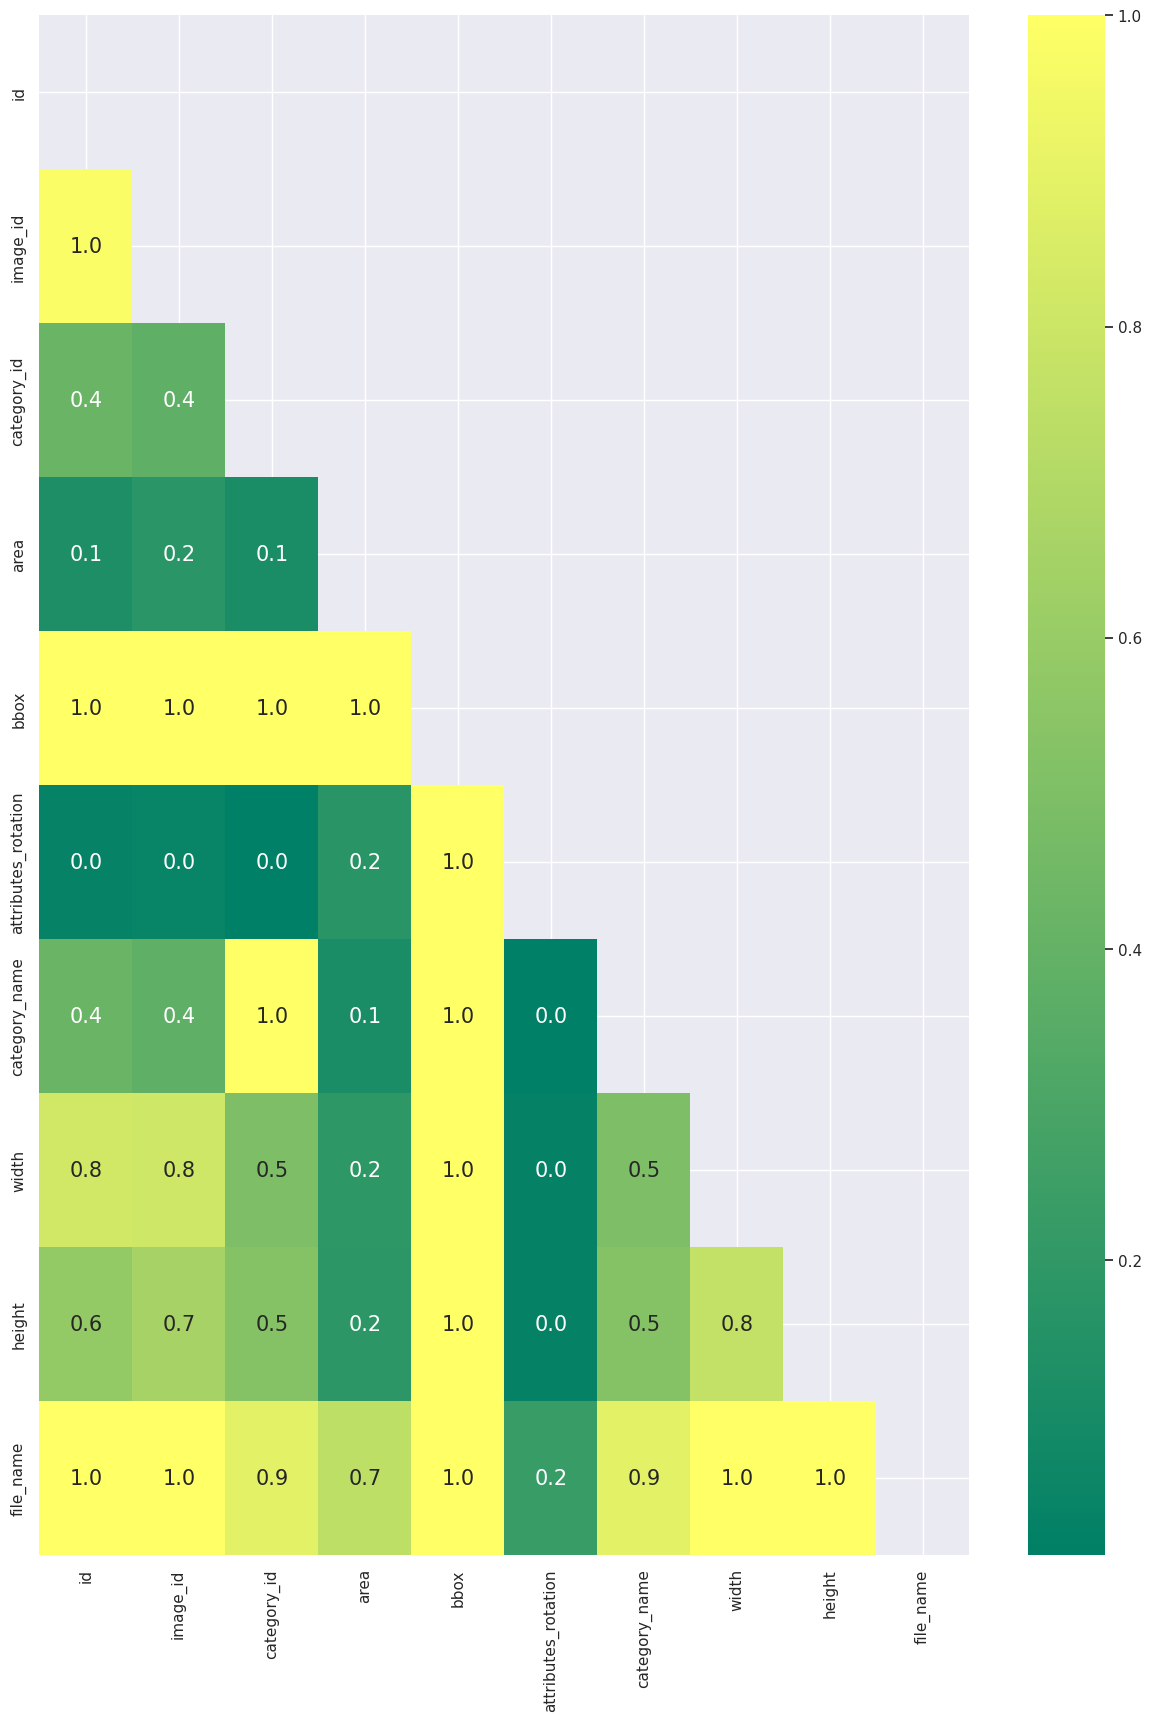

In [ ]:
display(d.phik_matrix()) # корреляция смешанных текстовых и числовых признаков
sb.set(rc={'figure.figsize':(15,20)}) # размер графика
sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
plt.show()

In [ ]:
  id_x	                  id_x
  image_id	              изображеия_id
  category_id	            категория_id
  segmentation	          сегментации
  area	                  номер участка
  bbox	                  координаты участка
  iscrowd	                ?
  attributes_occluded     завершон
  attributes_rotation	    процент завершения или вращение или смена
  category_name	          имя категории
  id_y	                  id_y
  width	                  ширина
  height	                высота
  file_name	              имя файла
  license	                лицензия
  flickr_url              эл. адресс1
  coco_url	              эл. адресс2
  date_captured           дата съёмки

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.
                                  )
train_datagen_flow = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/images/',
    target_size=(240, 240),
    batch_size=32,
    class_mode='sparse'
                                                      )
features, target = next(train_datagen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

Found 0 images belonging to 0 classes.


IndexError: ignored

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_datagen_flow = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/images',
    #target_size=(240, 240),
    batch_size=32,
    class_mode='sparse',
    subset='training'  # Указываем, что это обучающая выборка
)

features, target = next(train_datagen_flow)

# Выводим 15 изображений
fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', fontsize=20, fontweight=10, verticalalignment='baseline')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()
    plt.title('Age = {}, Image size - {}'.format(target[i], features[i].shape), loc='center')
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
from PIL import Image

# Путь к папке с фотографиями
folder_path = '/content/drive/MyDrive/Colab Notebooks/images'

# Получение списка файлов в папке
files = os.listdir(folder_path)

# Фильтрация только файлов с расширением 'jpg' или 'png'
photo_files = [f for f in files if f.endswith(('.jpg', '.png'))]

# Ограничение количества фотографий до 5
photo_files = photo_files[:5]

# Загрузка и отображение фотографий
for file_name in photo_files:
    file_path = os.path.join(folder_path, file_name)
    with Image.open(file_path) as img:
        img.show()

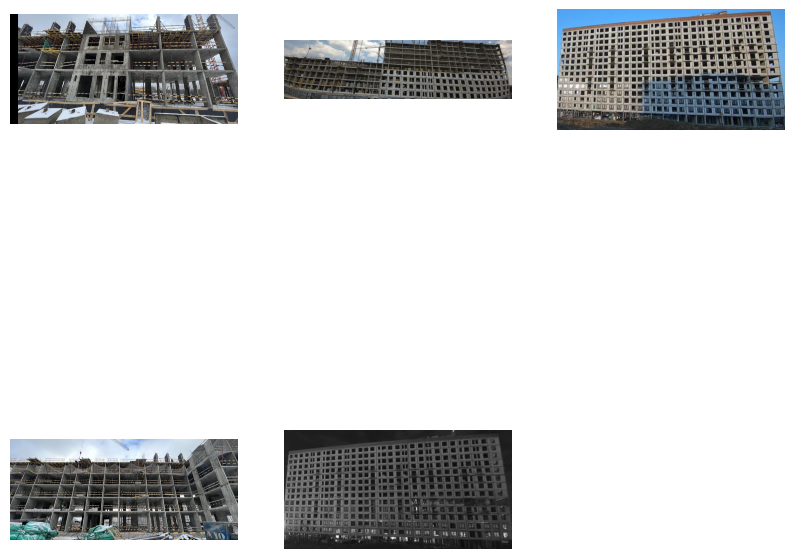

In [ ]:
import os
import matplotlib.pyplot as plt

# Путь к папке с фотографиями
folder_path = '/content/drive/MyDrive/Colab Notebooks/images'

# Получение списка файлов в папке
files = os.listdir(folder_path)

# Фильтрация только файлов с расширением 'jpg' или 'png'
photo_files = [f for f in files if f.endswith(('.jpg', '.png'))]

# Ограничение количества фотографий до 5
photo_files = photo_files[:5]

# Отображение фотографий
fig = plt.figure(figsize=(10, 10))

for i, file_name in enumerate(photo_files):
    file_path = os.path.join(folder_path, file_name)
    img = plt.imread(file_path)
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Загрузка данных и предобработка изображений
data_directory = '/content/drive/MyDrive/Colab Notebooks/images'
json_file = '/content/instances_default.json'

with open(json_file, 'r') as file:
    data = json.load(file)

image_paths = []
labels = []

for entry in data:
    image_paths.append(f"{data_directory}/{entry['filename']}")
    labels.append(entry['stage'])  # Здесь предполагается, что поле с меткой называется "stage"

# Конвертация меток в числовой формат (sparse классификация)
class_mapping = {stage: i for i, stage in enumerate(set(labels))}
labels = [class_mapping[label] for label in labels]

# Создание ImageDataGenerator для предобработки изображений
image_size = (240, 240)
batch_size = 32

data_generator = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Загрузка предобученной модели ResNet50 без головы классификатора
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(240, 240, 3))

# Добавление слоев над основной моделью
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(class_mapping), activation='softmax')(x)

# Создание финальной модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция и обучение модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Здесь вы можете настроить параметры обучения, такие как количество эпох и т.д.
epochs = 10

model.fit(train_data_flow, steps_per_epoch=train_data_flow.samples // batch_size,
          validation_data=val_data_flow, validation_steps=val_data_flow.samples // batch_size,
          epochs=epochs)

# Сохранение модели
model.save('/content/drive/MyDrive/Colab Notebooks/stage_classification_model.h5')

TypeError: ignored

In [ ]:
/content/IMG_20221108_164628_933.jpg

In [ ]:
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Загрузка данных и предобработка изображений
data_directory = '/content/drive/MyDrive/Colab Notebooks/images'
json_file = '/content/instances_default.json'

with open(json_file, 'r') as file:
    data = json.load(file)

image_paths = []
labels = []

for entry in data:
    filename = entry['filename']
    image_name = os.path.splitext(filename)[0]
    image_paths.append(f"{data_directory}/{image_name}")
    labels.append(entry['stage'])  # Здесь предполагается, что поле с меткой называется "stage"

# Конвертация меток в числовой формат (sparse классификация)
class_mapping = {stage: i for i, stage in enumerate(set(labels))}
labels = [class_mapping[label] for label in labels]

# Создание ImageDataGenerator для предобработки изображений
image_size = (240, 240)
batch_size = 32

data_generator = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Загрузка предобученной модели ResNet50 без головы классификатора
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(240, 240, 3))

# Добавление слоев над основной моделью
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(class_mapping), activation='softmax')(x)

# Создание финальной модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция и обучение модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Здесь вы можете настроить параметры обучения, такие как количество эпох и т.д.
epochs = 10

model.fit(train_data_flow, steps_per_epoch=train_data_flow.samples // batch_size,
          validation_data=val_data_flow, validation_steps=val_data_flow.samples // batch_size,
          epochs=epochs)

# Сохранение модели
model.save('/content/drive/MyDrive/Colab Notebooks/stage_classification_model.h5')

TypeError: ignored

In [ ]:
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AveragePrecision

# Загрузка данных и предобработка изображений
data_directory = '/content/drive/MyDrive/Colab Notebooks/images'
json_file = '/content/instances_default.json'

with open(json_file, 'r') as file:
    data = json.load(file)

image_paths = []
labels = []

for entry in data:
    filename = entry
    image_name = os.path.splitext(filename)[0]
    image_paths.append(f"{data_directory}/{image_name}")
    labels.append(data[entry]['stage'])  # Исправленный код для получения метки

# Конвертация меток в числовой формат (sparse классификация)
class_mapping = {stage: i for i, stage in enumerate(set(labels))}
labels = [class_mapping[label] for label in labels]

# Создание ImageDataGenerator для предобработки изображений
image_size = (240, 240)
batch_size = 32

data_generator = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)

train_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_data_flow = data_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Загрузка предобученной модели ResNet50 без головы классификатора
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(240, 240, 3))

# Добавление слоев над основной моделью
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(class_mapping), activation='softmax')(x)

# Создание финальной модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция и обучение модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=[AveragePrecision(name='AP', top_k=len(class_mapping), threshold=0.5)])

# Здесь вы можете настроить параметры обучения, такие как количество эпох и т.д.
epochs = 10

model.fit(train_data_flow, steps_per_epoch=train_data_flow.samples // batch_size,
          validation_data=val_data_flow, validation_steps=val_data_flow.samples // batch_size,
          epochs=epochs)

# Сохранение модели
model.save('/content/drive/MyDrive/Colab Notebooks/stage_classification_model.h5')

ImportError: ignored

In [ ]:
!pip install tf-metrics
from tf_metrics.metrics import AveragePrecision

ERROR: Could not find a version that satisfies the requirement tf-metrics (from versions: none)
ERROR: No matching distribution found for tf-metrics


ModuleNotFoundError: ignored